In [1]:
from datetime import datetime, date, time, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from utils import *
from median_optimization import optimal_median
from prophet import Prophet

In [2]:
TRAIN_START = "2023-10-02 00:00"
TRAIN_END = "2023-12-17 23:59"


TEST_START = "2023-12-01 00:00"
TEST_END = "2023-12-14 23:59"
test_rain_dates = []

PUBLIC_START = "2023-10-21 00:00"
PUBLIC_END = "2023-10-24 23:59"
public_rain_dates = []

PRIVATE_START = "2023-12-18 00:00"
PRIVARE_END = "2023-12-24 23:59"
private_rain_dates = [date(2023, 12, 19), date(2023,12,20)]


In [3]:
with open("./cache/small_data_cache.pkl", "rb") as f:
    df = pd.read_pickle(f)
with open("../html.2023.final.data/sno_test_set.txt") as f:
    ntu_snos = [l.strip() for l in f.read().splitlines()]
with open("./cache/10-03_12_09_rain.pkl","rb") as f:
    rain_df = pd.read_pickle(f)

In [4]:
ntu_tots = get_tot(df, ntu_snos)
# the data looks like this:
"""
     datetime               sno      tot   sbi   bemp  act
0    2023-10-02 00:00:00  500101001  28.0  12.0  16.0   1
1    2023-10-02 00:01:00  500101001  28.0  12.0  16.0   1
2    2023-10-02 00:02:00  500101001  28.0  13.0  15.0   1
...
"""
holidays = [d for d in date_range(start=TRAIN_START, end=PRIVARE_END) if is_holiday(d)]

In [5]:
df['datehour'] = df['time'].dt.floor("H")


In [6]:
rain_df.rename(columns={'datetime':'datehour'},inplace=True)


argument rain to df

In [7]:
df = df.merge(rain_df,on='datehour',how='left')
df['rain'].fillna(0,inplace=True)
#print(df)
df.describe()

,tot,sbi,rain
count,1.105241e+07,1.105241e+07,1.105241e+07
mean,2.578958e+01,7.514006e+00,1.390311e-01
std,1.701789e+01,1.029793e+01,6.258437e-01
min,5.000000e+00,0.000000e+00,0.000000e+00
25%,1.500000e+01,1.000000e+00,0.000000e+00
50%,2.000000e+01,4.000000e+00,0.000000e+00
75%,3.000000e+01,1.100000e+01,0.000000e+00
max,9.900000e+01,9.900000e+01,9.000000e+00


In [8]:
morning_filter = (df["datehour"].dt.hour >= 7) & (df['datehour'].dt.hour <= 21)
rain_hours = df['datehour'][ (df["sno"] == "500101001") & morning_filter &(df['rain'] >= 0.3) ].drop_duplicates() # 0.3 for dribble , 0.5 for small rain
rain_dates = rain_hours.dt.date.drop_duplicates()

#print(rain_dates.describe()) # 0.3: 28, 0.5: 15 total:63-62 days

date_rain_hour_cnt = rain_hours.dt.date.value_counts()
#print(date_rain_hour_cnt)

In [9]:
long_rain_dates = rain_dates[rain_dates.isin(date_rain_hour_cnt.index[date_rain_hour_cnt >= 7])]
#print(long_rain_dates) # 12
#print(long_rain_dates.describe())
rainy_dates = long_rain_dates.array # 12
#print(rainy_dates)

[ datetime.date(2023, 10, 3),  datetime.date(2023, 10, 4),
  datetime.date(2023, 10, 5),  datetime.date(2023, 10, 6),
  datetime.date(2023, 10, 8), datetime.date(2023, 10, 20),
 datetime.date(2023, 10, 28), datetime.date(2023, 11, 16),
 datetime.date(2023, 11, 26), datetime.date(2023, 11, 30),
  datetime.date(2023, 12, 4),  datetime.date(2023, 12, 6)]

replace rain to is rainy day

In [ ]:
df['rain'] = df['time'].dt.date.isin(rainy_dates)

delete rain processing variables

In [10]:
del rain_df
del morning_filter
del rain_hours, rain_dates
del date_rain_hour_cnt
del long_rain_dates

Only one main table. Then always slice from it

In [11]:
df.drop(columns=["tot","datehour", "act"],inplace=True)


In [12]:
df.rename(columns={"time": "ds", "sbi": "y"},inplace=True)
#print(df)

In [ ]:
#df['holiday'] = df['time'].dt.date.isin(holidays)
holidays_df = pd.DataFrame({
  'holiday': 'holiday',
  'ds': pd.to_datetime(holidays),
  'lower_window': 0,
  'upper_window': 1,
})

Training about 12min

In [ ]:
import concurrent.futures

train = df[df["ds"].dt.date.isin(date_range(TRAIN_START, TRAIN_END))].copy()
pred_dfs = {}
models = {}

test_df = pd.DataFrame({'ds': pd.date_range(TEST_START, TEST_END, freq="20min")})
test_df['rain'] = test_df['ds'].dt.date.isin(rainy_dates)

# Function to train and predict for a single station
def train_and_predict(sno, train_data, test_start, test_end):
    station_train = train_data[train_data['sno'] == sno]
    m = Prophet(holidays=holidays_df)
    m.add_regressor('rain',prior_scale=5) # assume not too big effect
    m.fit(station_train[['ds', 'y', 'rain']])
    
    forecast = m.predict(test_df)
    
    return sno, forecast, m

# Train and predict for each station in parallel
with concurrent.futures.ProcessPoolExecutor(max_workers=25) as executor:
    # Submit jobs for each station
    future_to_sno = {executor.submit(train_and_predict, sno, train, TEST_START, TEST_END): sno for sno in ntu_snos}
    
    # Retrieve results as they become available
    for future in concurrent.futures.as_completed(future_to_sno):
        sno = future_to_sno[future]
        try:
            result_sno, forecast_sno, model_sno = future.result()
            pred_dfs[result_sno] = forecast_sno
            models[result_sno] = model_sno
        except Exception as e:
            print(f"Error processing station {sno}: {e}")

In [19]:
print(pred_dfs[ntu_snos[2]])

                      ds     trend  yhat_lower  yhat_upper  trend_lower  \
0    2023-12-01 00:00:00  8.701085    5.963460   15.771969     8.701085   
1    2023-12-01 00:20:00  8.706692    6.038283   15.622444     8.706692   
2    2023-12-01 00:40:00  8.712299    6.426742   16.349559     8.712299   
3    2023-12-01 01:00:00  8.717906    7.086356   16.606605     8.717906   
4    2023-12-01 01:20:00  8.723513    6.899547   16.448939     8.723513   
...                  ...       ...         ...         ...          ...   
1003 2023-12-14 22:20:00  5.361403   -0.418027    9.786119     5.361403   
1004 2023-12-14 22:40:00  5.357664    1.106505   10.014453     5.357664   
1005 2023-12-14 23:00:00  5.353926    1.234868   10.633840     5.353926   
1006 2023-12-14 23:20:00  5.350187    1.629185   11.217760     5.350187   
1007 2023-12-14 23:40:00  5.346448    1.953340   11.577657     5.346448   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0        8.701085 

/home/student/10/b10902118/tmp/anaconda3/envs/ml/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/student/10/b10902118/tmp/anaconda3/envs/ml/lib/python3.10/site-packages/prophet/plot.py:395: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/home/student/10/b10902118/tmp/anaconda3/envs/ml/lib/python3.10/site-packages/prophet/plot.py:399: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

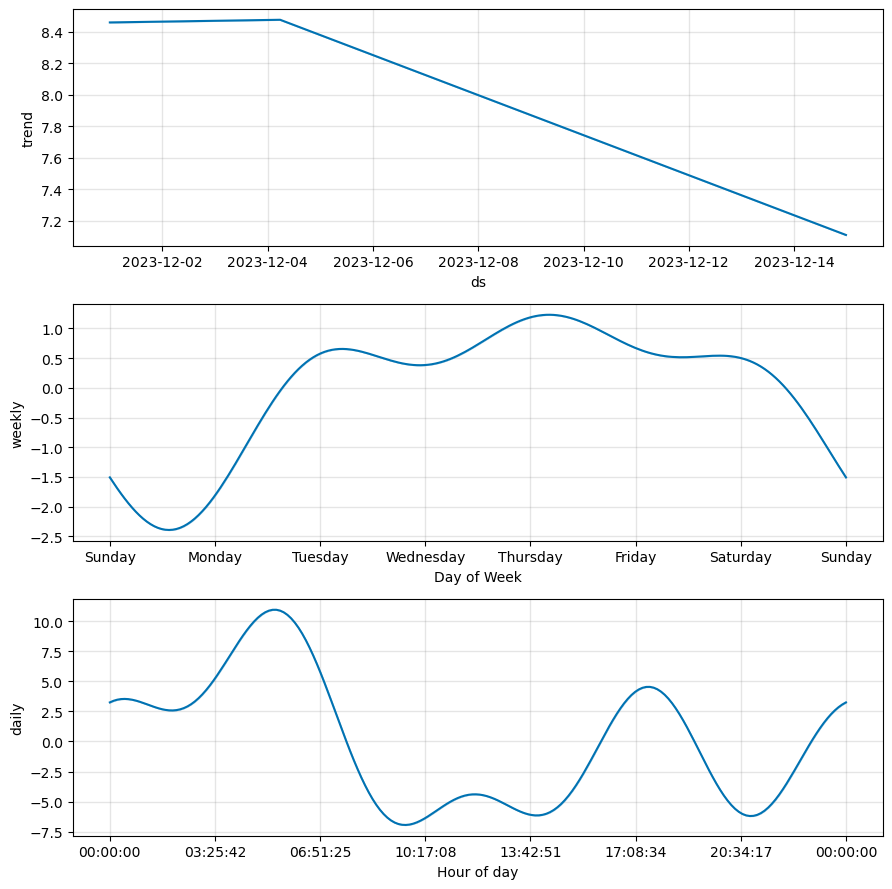

In [23]:
pred_df = pred_dfs[ntu_snos[0]]
m = models[ntu_snos[0]]
fig = m.plot_components(pred_df)
plt.savefig(f"./prophet_lines/{ntu_snos[0]}_components.png")
plt.close(fig)


In [32]:
test_range = pd.date_range(TEST_START, TEST_END, freq="20min")
test_len = len(list(test_range))
test_df = df[df["ds"].isin(test_range)]
test_tb = (
    pd.pivot_table(test_df, index="ds", columns="sno", values="y")
    .resample("20min")
    .agg("first")
    .bfill()
    .ffill()
)

In [44]:
y_pred = np.empty([test_len,0])

errors = {}
for sno, tot in zip(ntu_snos,ntu_tots):
    pred_df = pred_dfs[sno]
    m = models[sno]
    fig = m.plot_components(pred_df)
    plt.savefig(f"./prophet_lines/{sno}_components.png")
    plt.close(fig)
    
    pred_df['yhat'].clip(lower=0, upper=tot,inplace=True)
    pred = pred_df['yhat'].to_numpy()
    y_pred = np.column_stack((y_pred,pred))

    #TODO E_in
    
    ans = test_tb[sno]
    #print(ans.shape, pred_df.shape)
    err = error(ans.to_numpy(), pred,np.full(test_len, tot))
    errors[sno] = err
    

    ax = pred_df.plot(x='ds',y='yhat',figsize=(20, 6),title=f"score: {err}")
    ans.plot(ax=ax, x='ds', y='y')
    plt.savefig(f"./prophet_lines/{sno}.png")
    plt.close()

    

with open("./prophet_lines/results.txt","w") as f:
    for e in sorted(errors.items(), key=lambda x: x[1]):
        f.write(f"{e[0]}: {e[1]}\n")


/home/student/10/b10902118/tmp/anaconda3/envs/ml/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/student/10/b10902118/tmp/anaconda3/envs/ml/lib/python3.10/site-packages/prophet/plot.py:395: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/home/student/10/b10902118/tmp/anaconda3/envs/ml/lib/python3.10/site-packages/prophet/plot.py:399: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

Self evaluation (Test)

In [45]:

test = test_tb[test_tb.index.to_series().dt.date.isin(date_range(TEST_START, TEST_END))]
y_test = test.values

print_time_ranges(TRAIN_START, TRAIN_END, TEST_START, TEST_END)


Train: 10/02 - 12/17
Test: 12/01 - 12/14


In [47]:

#assert y_test.shape == y_pred.shape , "test pred shape not matched"
#y_pred = y_pred[:,1:]
#print(y_test.shape) #(1008, 112)
#print(y_pred.shape)


(1008, 112)
(1008, 112)


(288, 112) \
(288, 112)

MAE:  0.15802296025222282
Score:  0.33333666172134147


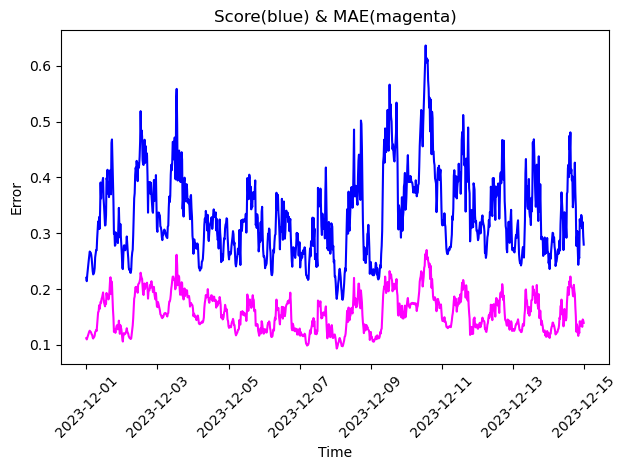

In [48]:
evaluation(y_test, y_pred, ntu_tots, test_range)


all sunny \
MAE:  0.13275823190272154 \
Score:  0.24003751756886713

all data \
MAE:  0.1229537906365303 \
Score:  0.21939612130515754

rain+sunny \
MAE:  0.12230290642321821 \
Score:  0.2167087889314868


does the same at public test set (2023/10/21 - 2023/10/24)

In [74]:
public_test_range = pd.date_range(PUBLIC_START, PUBLIC_END, freq="20min")
# list makes indexer 1D, or it is an 2D indexer
ftr = list(
    np.stack([[False]*(4*72),public_test_range.time, public_test_range.weekday]).T
)
y_public_df = result_df.loc[ftr]
#print("y_public_df Before")
#print(y_public_df)

Check public

In [75]:
#print("y_public_df After")
#print(y_public_df)

In [76]:
for col, tot in zip(y_public_df.columns, ntu_tots):
    y_public_df[col] = y_public_df[col].clip(lower=0, upper=tot)
y_public_test = y_public_df.values
public_test_df = pd.DataFrame(y_public_test, columns=ntu_snos, index=public_test_range)

In [77]:
private_test_range = pd.date_range(PRIVATE_START, PRIVARE_END, freq="20min")
ftr = list(
    np.stack(
        [[d in private_rain_dates for d in private_test_range.date],private_test_range.time, private_test_range.weekday]
    ).T
)
y_private_df = result_df.loc[ftr]

# TODO patch private
# Set the initial time
current_datetime = pd.to_datetime("2023-12-17 22:40")
current_time = current_datetime.time()
cur_data = tb[tb.index == current_datetime]
print(cur_data)
cur = tb[tb.index.to_series().dt.time == current_time]

# Loop to fetch data for the next 20 minutes
end_datetime = pd.to_datetime("2023-12-18 04:00")
next_datetime = current_datetime + timedelta(minutes=60)
td = timedelta(minutes=20)
total_td = timedelta(minutes=60)
while next_datetime <= end_datetime:
    # Increment current_time by 20 minutes
    next_datetime += td
    next_time = next_datetime.time()
    total_td += td
    # Filter data from tb for the current time
    nxt = tb[tb.index.to_series().dt.time == next_time]
    diff = nxt - cur.shift(freq=total_td)
    mean_diff = pd.pivot_table(diff.mean().reset_index(), columns="sno")
    mean_diff.set_index(cur_data.index, inplace=True)
    upd = cur_data + mean_diff
    print(upd)
    patch_datetime = next_datetime 
    patch_time = patch_datetime.time()
    print(patch_time)
    upd.set_index([[patch_time], [0]], inplace=True)
    y_private_df.loc[(patch_time, 0)] = upd

if y_private_df.isnull().values.any():
    print("DataFrame contains NaN values.")
print(y_private_df)

In [79]:
assert not y_private_df.isnull().values.any(), "private contains null"
for col, tot in zip(y_private_df.columns, ntu_tots):
    y_private_df[col] = y_private_df[col].clip(lower=0, upper=tot)
y_private_test = y_private_df.values
private_test_df = pd.DataFrame(
    y_private_test, columns=ntu_snos, index=private_test_range
)

In [80]:
tmp = pd.concat(
    [
        public_test_df,
        private_test_df,
    ]
)
# reset_index: old index => "time" column
# id_vars: fixed column like index
# var_name: columns.name to "sno" column
# value_name: value => "sbi" column
tmp = tmp.reset_index(names="time").melt(
    id_vars="time", var_name="sno", value_name="sbi"
)
out_df = pd.DataFrame(
    {
        "id": (
            tmp["time"].dt.strftime("%Y%m%d")
            + "_"
            + tmp["sno"]
            + "_"
            + tmp["time"].dt.strftime("%H:%M")
        ),
        "sbi": tmp["sbi"],
    }
)
out_df.to_csv(
    f"../submission/pub_pri_{datetime.now().strftime('%m-%d-%H-%M')}.csv", index=False
)
print("csv created")

csv created


TODO patch private<br>
Set the initial time


<br>
current_datetime = pd.to_datetime("2023-12-10 23:40")<br>
current_time = current_datetime.time()<br>
cur_data = old_tb[old_tb.index == current_datetime]<br>
print(cur_data)<br>
cur = old_tb[old_tb.index.to_series().dt.time == current_time]<br>
# Loop to fetch data for the next 20 minutes<br>
end_datetime = pd.to_datetime("2023-12-04 03:59")<br>
next_datetime = current_datetime<br>
td = timedelta(minutes=20)<br>
total_td = timedelta(minutes=0)<br>
while next_datetime <= end_datetime:<br>
    # Increment current_time by 20 minutes<br>
    next_datetime += td<br>
    next_time = next_datetime.time()<br>
    total_td += td<br>
    # Filter data from old_tb for the current time<br>
    nxt = old_tb[old_tb.index.to_series().dt.time == next_time]<br>
    diff = nxt - cur.shift(freq=total_td)<br>
    mean_diff = pd.pivot_table(diff.mean().reset_index(), columns="sno")<br>
    mean_diff.set_index(cur_data.index, inplace=True)<br>
    upd = cur_data + mean_diff<br>
    # print(upd)<br>
    patch_datetime = next_datetime + timedelta(minutes=1)<br>
    patch_time = patch_datetime.time()<br>
    upd.set_index([[patch_time], [0]], inplace=True)<br>
    y_private_df.loc[(patch_time, 0)] = upd<br>
print(y_private_df)<br>


convert the prediction to the required format